____________________________________________
START Data Pre-processing
____________________________________________
Encoding labels...
Encoding addressess...
Encoding functions...
Encoding command responses...
Extracting payload features...
[('setpoint', '<f8'), ('gain', '<f8'), ('reset rate', '<f8'), ('deadband', '<f8'), ('cycle time', '<f8'), ('rate', '<f8'), ('system mode', '<f8'), ('control scheme', '<f8'), ('pump', '<f8'), ('solenoid', '<f8'), ('pressure measurement', '<f8')]
	Adding length...
	Adding crc rate...
	Adding timestamp differences...

	Splitting dataset...
Encoding function...
Imputing payload using indicators
Additional features were found!
Encoding function...
Imputing payload using indicators
Additional features were found!
Encoding function...
Imputing payload using indicators
Additional features were found!
Encoding function...
Imputing payload using indicators
Additional features were found!
Encoding function...
Imputing payload using indicators
Additional featur

<Figure size 432x288 with 0 Axes>

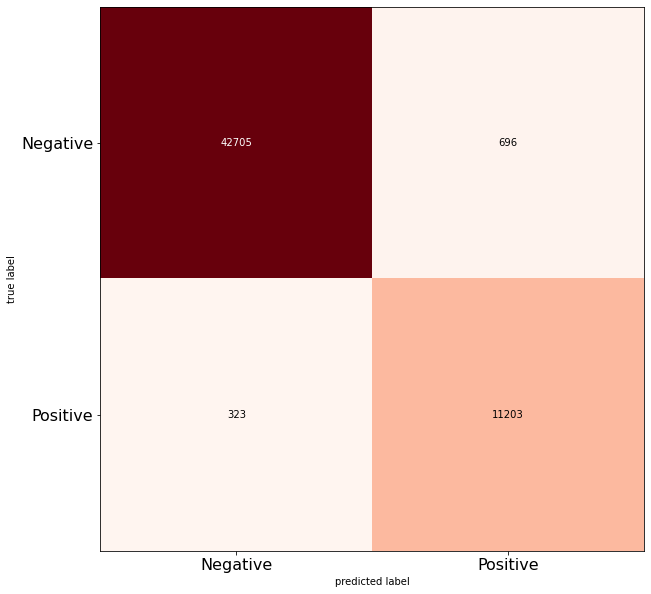

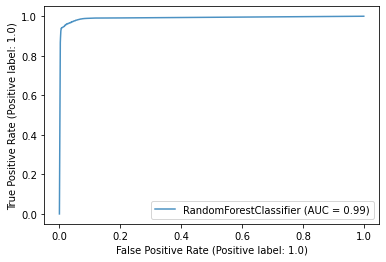

In [2]:
#--------------------#
# Import statements #
#--------------------#

import numpy as np
from numpy.lib.recfunctions import repack_fields

import time
import scipy, argparse, itertools, os
from scipy.io import arff

import sklearn.utils
from sklearn.utils import shuffle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Output
import warnings 
warnings.filterwarnings("ignore")

#Visualizations
import matplotlib.pyplot as mp
%matplotlib inline

import plotly as pl
import plotly.offline as plo
import plotly.graph_objs as plg
import seaborn as sb
import pandas as pd

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import metrics

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC

from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

#Models

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from keras.utils import np_utils


from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

#--------------------#
# Classes & Methods #
#--------------------#

#Class: MaskedStandardScaler
class MSS:

  def fit_transform(self, Xs):
    self.mean = Xs.mean(axis=0)
    self.std = Xs.std(axis=0)
    return self.transform(Xs)

  def transform(self, Xs):
    return (Xs - self.mean) / self.std

#Class: MaskedMinMaxScaler
class MMMS:

  def fit_transform(self, Xs):
    self.min = Xs.min(axis=0)
    self.max = Xs.max(axis=0)
    return self.transform(Xs)

  def transform(self, Xs):
    return (Xs - self.min) / (self.max - self.min)

def tocategoricalwithnans(Xs, n_cats):
  categorized = np.zeros((len(Xs), n_cats))
  for n, v in enumerate(np.array(Xs)):
    if not np.isnan(v):
      categorized[n, int(v)] = 1 
  return categorized

def pairwise(iterable):
  a, b = itertools.tee(iterable)
  next(b, None)
  return zip(a, b)

def splitdataset(data, labels, train_per_split, val_per_split, test_per_split):
  assert (train_per_split + val_per_split + test_per_split) <= 1.0
  
  train_end_index = int(data.shape[0] * train_per_split)
  valid_end_index = int(data.shape[0] * val_per_split) + train_end_index

  X_train, Y_train = data[:train_end_index], labels[:train_end_index]
  X_valid, Y_valid = data[train_end_index:valid_end_index], labels[train_end_index:valid_end_index]
  X_test,  Y_test  = data[valid_end_index:], labels[valid_end_index:]
  
  return (X_train, X_valid, X_test), (Y_train, Y_valid, Y_test)

def normalize(Xs, op, train_data_model):

  ops = { 
    'mean'     : preprocessing.StandardScaler,
    'minmax'   : preprocessing.MinMaxScaler,
    'm-mean'   : MSS,
    'm-minmax' : MMMS
  }

  if not train_data_model:
    model = ops[op]()
    Xs = model.fit_transform(Xs)
    return Xs, model
  else:
    return train_data_model.transform(Xs), None

def getclustermodelk(model, flags):
  if flags.payload_kmeans_imputed:
    return model.cluster_centers_.shape[0]
  elif flags.payload_gmm_imputed:
    return model.weights_.shape[0]

def clusterpayloadfeatures(payloads, flags, train_data_model):
  groups = grouppayloads(payloads)
  groups_ids = [np.where(groups == i)[0] for i in range(3)]

  only_nans = np.zeros_like(groups_ids[0])
  only_pres = payloads[groups_ids[1]][:,-1].reshape((-1, 1))
  wo_pres   = payloads[groups_ids[2]][:,:-1]

  if not train_data_model:
    
    if flags.payload_kmeans_imputed:
      print('Imputing payload with kmeans')
      k1, k2 = flags.payload_kmeans_imputed
      cluster_func = clusterkmeans
    elif flags.payload_gmm_imputed:
      print('Imputing payload with GMM')
      k1, k2 = flags.payload_gmm_imputed
      cluster_func = clustergmm

    only_pres, only_pressure_cluster_model = cluster_func(only_pres, \
      'pressure', elbow=flags.elbow, k=k1)
    wo_pres, wo_pressure_cluster_model = cluster_func(wo_pres, \
      'remaining payload features', elbow=flags.elbow, k=k2)

  else:
    only_pressure_cluster_model = train_data_model['only_pressure']
    wo_pressure_cluster_model = train_data_model['wo_pressure']
    only_pres = only_pressure_cluster_model.predict(only_pres)
    wo_pres = wo_pressure_cluster_model.predict(wo_pres)

  only_pres += 1
  wo_pres += (getclustermodelk(only_pressure_cluster_model, flags) + 1)

  combined_cat = np.concatenate((only_nans, only_pres, wo_pres))
  combined_ind = np.concatenate(groups_ids)
  combined = sorted(zip(combined_ind, combined_cat), key=lambda x: x[0])
  combined = np.array([x[1] for x in combined])

  models = {
    'only_pressure' : only_pressure_cluster_model,
    'wo_pressure' : wo_pressure_cluster_model
  }

  return np_utils.to_categorical(combined), models

def preprocesspayloadfeaturesfulldataset(payloads, flags):


  print('Imputing payload - keeping old value')
  
  print('pressure measurement')
  pressures_f = payloads[:,-1]
  pressure_not_nans = np.where(~np.isnan(pressures_f))[0]
  imputebykeepinglastvalue(pressures_f, pressure_not_nans)

  print('binary payload')
  binary_f = payloads[:,-4:-1]
  binary_f_not_nans = np.where(~np.isnan(binary_f)[:,0])[0]
  imputebykeepinglastvalue(binary_f, binary_f_not_nans)

  print('system mode payload')
  system_f = payloads[:,-5]
  system_f_not_nans = np.where(~np.isnan(system_f))[0]
  imputebykeepinglastvalue(system_f, system_f_not_nans)

  print('real valued payload')
  real_val_payloads_f = payloads[:,:-5]
  real_val_payloads_f_not_nans = np.where(~np.isnan(real_val_payloads_f)[:,0])[0]
  imputebykeepinglastvalue(real_val_payloads_f, real_val_payloads_f_not_nans)

  '''restack'''
  payloads = np.column_stack((
    real_val_payloads_f,
    system_f,
    binary_f,
    pressures_f
  ))
  return payloads


def preprocessdatafulldataset(Xs, flags):
  
  addresses = Xs[:, 0].reshape((-1, 1))
  responses = Xs[:, 2].reshape((-1, 1))

  functions = Xs[:, 1].reshape((-1, 1))
  payloads = Xs[:, 3:14]
  
  models = None

  payloads  = preprocesspayloadfeaturesfulldataset(payloads, flags)

  stacked = np.column_stack((
    addresses, 
    functions, 
    responses,
    payloads
  ))

  if Xs.shape[1] >= 14:
    print('Additional features were found!')
    remaining = Xs[:, 14:]
    stacked = np.column_stack((stacked, remaining))

  return stacked

def preprocesspayloadfeatures(payloads, flags, train_data_model):

  if flags.payload_indicator_imputed:
    print('Imputing payload using indicators')
    indicators = np.isnan(payloads).astype(int)


    '''split'''
    realval_payload_f = payloads[:,:-5]
    pressure_f = payloads[:,-1].reshape((-1, 1))

    system_f = payloads[:,-5].reshape((-1, 1))
    binary_payload_f = payloads[:,-4:-1]

    '''categorize system_f feature'''
    system_f = np.ma.array(system_f, mask=np.isnan(system_f)) 
    system_f = tocategoricalwithnans(system_f, 3)

    '''masked normalization of realval payload features'''
    op = 'm-' + flags.normalize
    realval_payload_f = np.ma.array(realval_payload_f, mask=np.isnan(realval_payload_f)) 
    realval_payload_f, model = normalize(realval_payload_f, op, train_data_model)
    realval_payload_f = np.array(realval_payload_f)

    '''re-stack'''
    payloads = np.column_stack((
      realval_payload_f,
      system_f,
      binary_payload_f,
      pressure_f
    ))

    '''replace remaining NaNs with 0'''
    payloads[np.isnan(payloads)] = 0
    return np.column_stack((payloads, indicators)), model

  elif flags.payload_keep_value_imputed:
    print('Imputing payload features by keeping old value')
    
    print('pressure measurement')
    pressures_f = payloads[:,-1]

    print('binary payload')
    binary_f = payloads[:,-4:-1]

    print('system mode payload')
    system_f = payloads[:,-5]

    print('real valued payload')
    real_val_payloads_f = payloads[:,:-5]

    op = flags.normalize
    real_val_payloads_f, model = normalize(real_val_payloads_f, op, train_data_model)

    system_f = tocategoricalwithnans(system_f, 3)

    '''restack'''
    payloads = np.column_stack((
      real_val_payloads_f,
      system_f,
      binary_f,
      pressures_f
    ))
    return payloads, model

  else:
    return clusterpayloadfeatures(payloads, flags, train_data_model)

def imputebykeepinglastvalue(features, not_nans):
  first_not_nan = not_nans[0]
  features[:first_not_nan] = features[first_not_nan]

  for begin, end in pairwise(not_nans):
    features[begin:end] = features[begin]

  '''
  Case: To keep the value until the end of dataset
  '''
  last = len(features)
  last_not_nan = not_nans[-1]
  if last != last_not_nan:
    features[last_not_nan+1:] = features[last_not_nan]

def grouppayloads(payloads):
  '''
  Last two columns uniquely identify a category of payload
    both columns are NaNs -> 0
    first is NaN and second is not NaN -> 1
    first is not NaN and second is NaN -> 2
  Returns indicies
  '''
  ids = payloads[:,-2:]
  ids = np.packbits(~np.isnan(ids), axis=1) // 64
  return ids.reshape(-1)

def preprocessfunctioncodes(functions, flags, train_data_model):

  if flags.encode_function:    
    '''
    Encode function - same for training and validation/testing data
    '''
    print('Encoding function...')
    encoder = LabelEncoder()
    functions = encoder.fit_transform(functions.reshape(-1))
    return np_utils.to_categorical(functions), None

  if not train_data_model:

    if flags.cluster_function_kmeans != None:
      k = flags.cluster_function_kmeans
      predicted, model = clusterkmeans(functions, 'function', elbow=flags.elbow, k=k)
      return np_utils.to_categorical(predicted), model

    elif flags.cluster_function_gmm:
      k = flags.cluster_function_gmm
      predicted, model = clustergmm(functions, 'function', elbow=flags.elbow, k=k)
      return np_utils.to_categorical(predicted), model

  else:
    return np_utils.to_categorical(train_data_model.predict(functions)), None

def preprocessdata(Xs, flags, train_data_models = None):
  
  addresses = Xs[:, 0].reshape((-1, 1))
  responses = Xs[:, 2].reshape((-1, 1))

  functions = Xs[:, 1].reshape((-1, 1))
  payloads = Xs[:, 3:14]
  
  models = None

  if not train_data_models:
    functions, f_model = preprocessfunctioncodes(functions, flags, None)
    payloads, p_model  = preprocesspayloadfeatures(payloads, flags, None)
    models = {'function': f_model, 'payload': p_model}

  else:
    f_model = train_data_models['function']
    p_model = train_data_models['payload']

    functions, _ = preprocessfunctioncodes(functions, flags, f_model)
    payloads, _  = preprocesspayloadfeatures(payloads, flags, p_model)  

  stacked = np.column_stack((
    addresses, 
    functions, 
    responses,
    payloads
  ))

  if Xs.shape[1] >= 14:
    print('Additional features were found!')
    remaining = Xs[:, 14:]

    if not train_data_models:
      remaining, r_model = normalize(remaining, flags.normalize, None)

      models['remaining'] = r_model
    else:
      r_model = train_data_models['remaining']
      remaining, _ = normalize(remaining, flags.normalize, r_model)

    stacked = np.column_stack((stacked, remaining))

  return stacked, models

def cluster(model_class, score_func, Xs, feature_name, k, elbow, max_k):
  
  if elbow:
    models = [model_class(i).fit(Xs) for i in range(1, max_k+1)]
    scores = [score_func(model, Xs) for model in models]
    k = promptelbowmethod(scores, feature_name)

  m = model_class(k).fit(Xs)
  return m.predict(Xs), m

def clustergmm(Xs, feature_name, k=None, elbow=True):
  
  print('Clustering {} with GMM'.format(feature_name))
  GMM = lambda k: GaussianMixture(n_components=k, init_params='random')
  score_func = lambda gmm, Xs: gmm.aic(Xs)
  return cluster(GMM, score_func, Xs, feature_name, k, elbow, max_k=20)

def clusterkmeans(Xs, feature_name, k=None, elbow=True):
  
  print('Clustering {} with Kmeans'.format(feature_name))
  KM = lambda k: KMeans(n_clusters=k)
  score_func = lambda km, Xs: km.score(Xs)
  return cluster(KM, score_func, Xs, feature_name, k, elbow, max_k=10)

def promptelbowmethod(scores, feature_name):
  print(scores)
  xs = range(1, len(scores)+1)
  ys = np.array(scores)
  is_log = ''
  if np.all(ys > 0) or np.all(ys < 0):
    ys = np.log(np.abs(ys))
    is_log = 'log'
  print(ys)
  pl.plot(xs, ys)
  pl.xticks(xs)
  pl.xlabel('Number of clusters:')
  pl.ylabel('{} Score: '.format(is_log))
  pl.title('Elbow method - {}'.format(feature_name))
  pl.show()
  print('Enter number of clusters- {}:'.format(feature_name))
  k = int(input('-->'))
  print('\nselected k: {}'.format(k))
  return k

#-----------------------------------#
# Run Data Pre-processing Main Code #
#-----------------------------------#

if __name__ == '__main__':
  parser = argparse.ArgumentParser(description='Preprocess SCADA dataset.')
  parser.add_argument('-d', '--dataset', type=str, help='Dataset filename')
  parser.add_argument('--label', type=str, choices=['binary', 'category', 'dcategory'],
    default='binary', help='Type of labels to output in the preprocessed dataset')
  parser.add_argument('-t', '--time-series', action='store_true', 
    help='Keep temporal structure of the data')
  parser.add_argument('-n', '--normalize', type=str, choices=['mean', 'minmax'],
    default='mean', help='Type of normalization to preform')
  parser.add_argument('--discard-crc', action='store_true', 
    help='Remove CRC feature from the dataset')
  parser.add_argument('--discard-length', action='store_true', 
    help='Remove Length feature from the dataset')

  function_encoding_group = parser.add_mutually_exclusive_group(required=True)
  function_encoding_group.add_argument('--encode-function', action='store_true',
    help='Encode function codes with One-Hot encoding')
  function_encoding_group.add_argument('--cluster-function-kmeans', type=int,
    help='Cluster function codes with kmeans')
  function_encoding_group.add_argument('--cluster-function-gmm', type=int,
    help='Cluster function codes with GMM')

  payload_features_impution_group = parser.add_mutually_exclusive_group(required=True)
  payload_features_impution_group.add_argument('--payload-keep-value-imputed', action='store_true',
    help='Impute payload features by keeping the oldest value')
  payload_features_impution_group.add_argument('--payload-indicator-imputed', action='store_true',
    help='Impute payload features with 0\'s and add indicators')    
  payload_features_impution_group.add_argument('--payload-kmeans-imputed', type=int, nargs=2,
    help='Impute payload features using clustering with kmeans. Starting with pressure then remaining')
  payload_features_impution_group.add_argument('--payload-gmm-imputed', type=int, nargs=2,
    help='Impute payload features using clustering with GMM. Starting with pressure then remaining')    

  parser.add_argument('--elbow', action='store_true', 
    help='Clustering with elbow method for best number of clusters')

  parser.add_argument('-o', '--output', type=str, help='Output .npy files')
  parser.add_argument('--split', type=float, nargs=3, help='train/val/test split ratio')

  flags = parser.parse_args('-d ./dataset/IanArffDataset.arff --split 0.6 0.2 0.2 --encode-function --label binary --time-series -n mean --payload-indicator-imputed  -o processeddataset'.split())

  dataset, meta = arff.loadarff(flags.dataset)

  label_types = {
    'binary'    : 'binary result',
    'category'  : 'categorized result',
    'dcategory' : 'specific result'
  }

  print('____________________________________________')
  print('START Data Pre-processing')
  print('____________________________________________')
  print('Encoding labels...')
  label_name = label_types[flags.label]
  labels = dataset[label_name].astype(np.float)
  labels = labels.reshape((-1, 1))
  
  
  print('Encoding addressess...')
  #pre-process address before splitting, simple change of values and reshape into column vec
  addresses = preprocessing.label_binarize(dataset['address'], classes=[4])

  print('Encoding functions...')
  functions = dataset['function'].astype(np.float).reshape((-1, 1))

  print('Encoding command responses...')
  #pre-process address before splitting, parse string and reshape into column vec
  responses = dataset['command response'].astype(np.float).reshape((-1, 1))

  print('Extracting payload features...')
  payload_feature_names = meta.names()[3:14]
    
  payload_features = repack_fields(dataset[payload_feature_names])
  print(payload_features.dtype)
  payload_features = payload_features \
    .view(np.float64) \
    .reshape(payload_features.shape + (-1,))
    

  Xs = np.column_stack((
    addresses, 
    functions, 
    responses,
    payload_features
  ))

  if not flags.discard_length:
    print('\tAdding length...')
    lengths = dataset['length'].astype(np.float).reshape((-1, 1))
    Xs = np.column_stack((Xs, lengths))

  if not flags.discard_crc:
    print('\tAdding crc rate...')
    crcs = dataset['crc rate'].astype(np.float).reshape((-1, 1))
    Xs = np.column_stack((Xs, crcs))

  if flags.time_series:
    print('\tAdding timestamp differences...')
    Xs = np.column_stack((Xs, dataset['time']))
    

  if flags.payload_keep_value_imputed:

    Xs = preprocessdatafulldataset(Xs,flags)
    Xs, labels = sklearn.utils.shuffle(Xs, labels)

    print('\n\tSplitting dataset...')
    Xs, Ys = splitdataset(Xs, labels, *flags.split)
    Xs_train, Xs_val, Xs_test = Xs
    Ys_train, Ys_val, Ys_test = Ys

    Xs_train_val = np.concatenate((Xs_train,Xs_val))
    Ys_train_val = np.concatenate((Ys_train,Ys_val))

    Xs_train_test = Xs_test
    Ys_train_test = Ys_test

    Xs_train, train_models = preprocessdata(Xs_train, flags)
    Xs_train_val, train_models_val = preprocessdata(Xs_train_val, flags)
    Xs_val,  _ = preprocessdata(Xs_val,  flags, train_data_models=train_models)
    Xs_test, _ = preprocessdata(Xs_test, flags, train_data_models=train_models)
    Xs_train_test, _ = preprocessdata(Xs_train_test, flags, train_data_models=train_models_val)

  else:
    print('\n\tSplitting dataset...')
    Xs, labels = sklearn.utils.shuffle(Xs, labels)
    Xs, Ys = splitdataset(Xs, labels, *flags.split)
    Xs_train, Xs_val, Xs_test = Xs
    Ys_train, Ys_val, Ys_test = Ys

    Xs_train_val = np.concatenate((Xs_train,Xs_val))
    Ys_train_val = np.concatenate((Ys_train,Ys_val))
    Xs_train_test = Xs_test
    Ys_train_test = Ys_test

    Xs_train, train_models = preprocessdata(Xs_train, flags)
    Xs_val,  _ = preprocessdata(Xs_val,  flags, train_data_models=train_models)
    Xs_test, _ = preprocessdata(Xs_test, flags, train_data_models=train_models)

    Xs_train_val, train_models_val = preprocessdata(Xs_train_val, flags)
    Xs_train_test, _ = preprocessdata(Xs_train_test, flags, train_data_models=train_models_val)

    print(Xs_train_val.shape, Ys_train_val.shape)
    print(Xs_train_test.shape, Ys_train_test.shape)


  if not flags.time_series:
    Xs_train, Ys_train = sklearn.utils.shuffle(Xs_train, Ys_train, random_state=0)
 
  output_dir = flags.output

  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  np.save(os.path.join(output_dir, 'Xs_train'), Xs_train)
  np.save(os.path.join(output_dir, 'Xs_val'),   Xs_val)
  np.save(os.path.join(output_dir, 'Xs_test'),  Xs_test)

  np.save(os.path.join(output_dir, 'Ys_train'), Ys_train)
  np.save(os.path.join(output_dir, 'Ys_val'),   Ys_val)
  np.save(os.path.join(output_dir, 'Ys_test'),  Ys_test)

  np.save(os.path.join(output_dir, 'Xs_train_val'), Xs_train_val)
  np.save(os.path.join(output_dir, 'Xs_train_test'), Xs_train_test)
  np.save(os.path.join(output_dir, 'Ys_train_val'), Ys_train_val)
  np.save(os.path.join(output_dir, 'Ys_train_test'), Ys_train_test)
    
  print('____________________________________________')
  print('END Data Pre-processing')
  print('____________________________________________')
    
    
#-----------------------#  
# PREDICTION MODEL CODE #
#-----------------------#


def main():
  start_time = time.time()
  parser = argparse.ArgumentParser(description='Run RF:')
  parser.add_argument('-d', '--dataset', required=True, type=str, help='Data directory')
  parser.add_argument('-i', '--iters', default=10, type=int, help='Number of random samples')

  flags = parser.parse_args('-d ./processeddataset/ --i 1'.split())

  dataset_dir = flags.dataset
  dataset_filenames = [
    'Xs_train.npy', 'Xs_val.npy', 'Xs_test.npy', 'Xs_train_val.npy', 'Xs_train_test.npy',
    'Ys_train.npy', 'Ys_val.npy', 'Ys_test.npy', 'Ys_train_val.npy', 'Ys_train_test.npy'
  ]

  dataset_filenames = map(lambda x: os.path.join(dataset_dir, x), dataset_filenames)
  X_train, X_valid, X_test, Xs_train_val,Xs_train_test, Y_train, Y_valid, Y_test, Ys_train_val,Ys_train_test = map(np.load, dataset_filenames)
  
  n_label, label_dim = Y_train.shape
  print(np.unique(Y_train))
  print(label_dim)

  output_dir = os.path.join(dataset_dir, 'results_hyperparameters')
  if not os.path.exists(output_dir):
        os.makedirs(output_dir)
  '''
  if len(np.unique(Y_train)) > 8:
    print("More than 8 labels")
    category = {0:0, 1:4, 2:4, 3:4, 4:4, 5:4, 6:4, 7:4, 8:4, 9:4, 10:4, 11:4, 12:4,
                13:3, 14:3, 15:3, 16:3, 17:3, 18:6, 19:5, 20:7, 21:5, 22:5, 23:7, 24:7,
                25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 31:1, 32:1, 33:2, 34:2, 35:2}

    for i in range(Y_train.shape[0]):
      key = Y_train[i]
      Y_train[i] = category.get(key[0])
    for j in range(Y_valid.shape[0]):
      key = Y_valid[j]
      Y_valid[j] = category.get(key[0])
    for k in range(Y_test.shape[0]):
      key = Y_test[k]
      Y_test[k] = category.get(key[0])
  '''

  print('Label dimension is: {}'.format(label_dim))
  
  if not label_dim in [1, 2, 8, 36]:
    raise Exception('!Unknown label dimension: {}'.format(label_dim))



  for iterations in range(flags.iters):
    input_dim = X_train.shape[0]
    input_val = X_valid.shape[0]
    input_test= X_test.shape[0]
    print('Input dimension - training data: {}'.format(input_dim))
    print('Input dimension - validation data: {}'.format(input_val))
    print('Input dimension - test data: {}'.format(input_test))
    

    ne =  np.random.randint(2,100)
    md   = np.random.randint(2,100)

    cr = np.random.choice(['gini'])
    cw = 'balanced'
    #bo = False for Keep strategy and bo = True for the rest of the strategies
    bo = np.random.choice([False])
    #mf = 0.5 for Keep strategy and mf = None for the rest of the strategies
    mf = 0.5
    ws = False

    print('n_estimators: '+str(ne))
    print('criterion: '+str(cr))
    print('max_depth: '+str(md))
    print('bootstrap: '+str(bo))
    print('max max_features: '+str(mf))


    hyperparams = str(ne)+'--'+str(cr)+'--'+str(md)+'--'+str(bo)+'--balanced.txt'
    output_file = os.path.join(output_dir, hyperparams)
    with open(output_file, 'w') as f:
      f.write('Label dimension: {}'.format(label_dim)+"\n")
      f.write('Input dimension: {}'.format(input_dim)+"\n")


      clf = RandomForestClassifier(bootstrap=bo, class_weight= cw, criterion=cr,
            max_depth=md, max_features=mf, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=ne, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=ws)

      clf.fit(X_train, Y_train.ravel())

      predictions_train = clf.predict(X_train)  
      acc_train = accuracy_score(Y_train,predictions_train)
        
      predictions_val = clf.predict(X_valid)  
      acc_val = accuracy_score(Y_valid,predictions_val)
        
      classiReport = classification_report(Y_valid, predictions_val,digits=4)

      f.write('max_features: {}'.format(mf)+"\n")
      print("Accuracy on trainning data = "+str(acc_train))
      f.write("Accuray on training data = "+str(acc_train)+"\n")
      print("Accuray on validation data = "+str(acc_val))
      f.write("Accuray on validation data = "+str(acc_val)+"\n")
      print(classiReport)
      f.write(classiReport+"\n")

      print("--- %s seconds ---" % (time.time() - start_time))
      f.write("--- %s seconds ---" % (time.time() - start_time)+"\n")
        
        
      #--------------------#
      # Curve code - START #
      #--------------------#

      print('____________________________________________')
      print('VISUALIZATIONS & MORE')
      print('____________________________________________')
       
      print("Testing accuracy",clf.score(X_test, Y_test))
      print()

      YVTPrediction= clf.predict(X_test)

      print("\n Classification Score")
      print(metrics.classification_report(Y_test,YVTPrediction))


      cm=confusion_matrix(YVTPrediction, Y_test)
      mp.figure()
      plot_confusion_matrix(cm,figsize=(10,10), hide_ticks=True,cmap=mp.cm.Reds)
      mp.xticks(range(2), ['Negative', 'Positive'], fontsize=16,color='black')
      mp.yticks(range(2), ['Negative', 'Positive'], fontsize=16)
      mp.show()
        
      #svc = SVC(random_state=42)
      #svc.fit(X_train, Y_train)  
      ax = plt.gca()
      clf_disp = RocCurveDisplay.from_estimator(clf, X_test, Y_test, ax=ax, alpha=0.8)
      #svc_disp.plot(ax=ax, alpha=0.8)
      plt.show()
        
      #--------------------#
    # Curve code - END #
    #--------------------#


if __name__ == '__main__':
  main()

